In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import csv
import statsmodels.api as sm

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [4]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [5]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
print df.shape

(891, 12)


In [7]:
df['Gender'] = df['Sex'].map({'female':1, 'male':0}).astype(int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [8]:
if len(df.Embarked[df.Embarked.isnull()]) > 0:
    df.Embarked[df.Embarked.isnull()] = df.Embarked.dropna().mode().values

C:\Users\guhemant\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
median_age = df.Age.dropna().median()
if len(df.Age[df.Age.isnull()]) > 0:
    df.loc[(df.Age.isnull()), 'Age'] = median_age

In [10]:
ports = list(enumerate(np.unique(df.Embarked)))
ports_dict = {name:i for i, name in ports}
df.Embarked = df.Embarked.map(lambda x: ports_dict[x]).astype(int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,2,0


In [11]:
Y = df['Survived'].values
df_tmp = df.drop(['Name','Sex','Ticket','Cabin','PassengerId'], axis = 1)
X = df_tmp.as_matrix()

In [12]:
Xnames = list(df_tmp.columns.values)
Xnames.remove('Survived')
Xnames

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Gender']

In [13]:
df_tmp = df_tmp.values

In [14]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [16]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {'n_estimators': range(1,20), 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                            df, Xnames, 'Survived', 1, mask=mask,score_func='f1',n_jobs=4)

C:\Users\guhemant\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'min_samples_leaf': 1, 'n_estimators': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 5} 0.743524035876 [mean: 0.59452, std: 0.12085, params: {'min_samples_leaf': 1, 'n_estimators': 1, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 2}, mean: 0.62256, std: 0.14208, params: {'min_samples_leaf': 1, 'n_estimators': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 2}, mean: 0.49178, std: 0.12941, params: {'min_samples_leaf': 1, 'n_estimators': 3, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 2}, mean: 0.54381, std: 0.11614, params: {'min_samples_leaf': 1, 'n_estimators': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 2}, mean: 0.63332, std: 0.07590, params: {'min_samples_leaf': 1, 'n_estimators': 5, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_dept

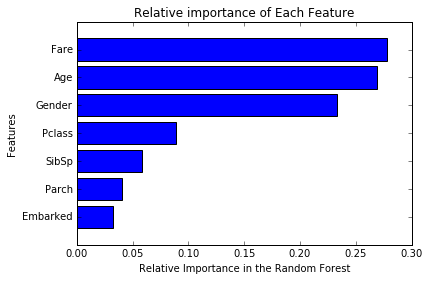

In [15]:
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [16]:
test_df = pd.read_csv('test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
test_df['Gender'] = test_df.Sex.map({'female':0, 'male':1}).astype(int)

In [18]:
if len(test_df.Embarked[test_df.Embarked.isnull()]) > 0:
    test_df.Embarked[test_df.Embarked.isnull()] = test_df.Embarked.dropna().mode().values

In [19]:
test_df.Embarked = test_df.Embarked.map(lambda x: ports_dict[x]).astype(int)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,2,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,2,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,2,0


In [20]:
median_age = test_df['Age'].dropna().median()
if len(test_df.Age[ test_df.Age.isnull() ]) > 0:
    test_df.loc[ (test_df.Age.isnull()), 'Age'] = median_age

In [21]:
if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
    median_fare = np.zeros(3)
    for f in range(0,3):     
        median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):
        test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]

In [22]:
ids = test_df['PassengerId'].values

In [23]:
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
0,3,34.5,0,0,7.8292,1,1
1,3,47.0,1,0,7.0000,2,0
2,2,62.0,0,0,9.6875,1,1
3,3,27.0,0,0,8.6625,2,1
4,3,22.0,1,1,12.2875,2,0


In [24]:
test_data = test_df.values

In [25]:
print 'Training...'
forest = RandomForestClassifier(n_estimators=11)
forest = forest.fit( df_tmp[0::,1::], df_tmp[0::,0] )

print 'Predicting...'
output = forest.predict(test_data).astype(int)

predictions_file = open("Output.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'

Training...
Predicting...
Done.
